### Product Sentiment Analysis using Deep Learning in Keras

In this notebook, we build a convolutional neural net to classify amazon mobile reviews by their sentiment.
This the part of a POC to build as snentiment anlayser for the qualitative feed back we receive.

### Load dependencies

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


### Loading data

In [3]:
reviews = pd.read_csv('./data/Amazon_Unlocked_Mobile.csv')

In [4]:
reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [5]:
reviews.shape

(413840, 6)

#### Data Preprocessing

In [6]:
# Understanding diffrent classes in Ratings

reviews.Rating.value_counts()

5    223605
1     72350
4     61392
3     31765
2     24728
Name: Rating, dtype: int64

We will only consider rating 5 and rating 1, Value 5 is a highly postive rating and 1 as a negative rating, this will help us seprate them with high degree of polarity between negative and positive sentiments.

In [7]:
reviews_sub = reviews[(reviews['Rating'] == 5) | (reviews['Rating'] == 1)]

In [8]:
reviews_sub.Rating.value_counts()

5    223605
1     72350
Name: Rating, dtype: int64

In [9]:
#mapping the data or ratings to 0 and 1, where 0 is negative and 1 is positive
reviews_map = reviews_sub.loc[:, ['Reviews', 'Rating']]
reviews_map['mapped_rating'] = reviews_map['Rating'].map({5:1, 1:0})

In [10]:
reviews_map.head()

,Reviews,Rating,mapped_rating
0,I feel so LUCKY to have found this used (phone...,5,1
2,Very pleased,5,1
5,I already had a phone with problems... I know ...,1,0
8,I originally was using the Samsung S2 Galaxy f...,5,1
11,This is a great product it came after two days...,5,1


In [11]:
# checking for missing vaues
reviews_map.isnull().sum()

Reviews          38
Rating            0
mapped_rating     0
dtype: int64

In [12]:
# droping null vlues
reviews_map = reviews_map.dropna()

In [13]:
# one againg checking for missing vaues
reviews_map.isnull().sum()

Reviews          0
Rating           0
mapped_rating    0
dtype: int64

In [14]:
# Splting the data for traing and testing
from sklearn.model_selection import train_test_split

X = reviews_map['Reviews']
y = reviews_map['mapped_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)

(236733,)
(59184,)


### Cleaning Text

In [ ]:
import spacy
import nltk
import string
from nltk.corpus import stopwords
nlp = spacy.load('en_core_web_sm')
stpwrds = stopwords.words('english') + list(string.punctuation)

In [ ]:
# Function to preprocess text
def preprocess(text):
    doc = nlp(text, disable=['ner', 'parser'])
    tokens = [token.text for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_tokens = [token.lower() for token in tokens if token.isalpha() and token not in stpwrds]
    
    return ' '.join(a_tokens)

In [ ]:
# Applying the the text cleaing for train and test data
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Hyperperatmeter Tuning

In [17]:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
max_review_length = 400
n_unique_words = 5000 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

In [18]:
x_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_test = pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### CNN Architecture 

In [19]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [21]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [22]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[modelcheckpoint])

Train on 236733 samples, validate on 59184 samples
Epoch 1/4
236733/236733 [==============================] - 2817s 12ms/step - loss: 0.1037 - acc: 0.9622 - val_loss: 0.0640 - val_acc: 0.9800
Epoch 2/4
236733/236733 [==============================] - 2821s 12ms/step - loss: 0.0503 - acc: 0.9846 - val_loss: 0.0487 - val_acc: 0.9859
Epoch 3/4
236733/236733 [==============================] - 2831s 12ms/step - loss: 0.0361 - acc: 0.9894 - val_loss: 0.0430 - val_acc: 0.9876
Epoch 4/4
236733/236733 [==============================] - 2886s 12ms/step - loss: 0.0277 - acc: 0.9920 - val_loss: 0.0460 - val_acc: 0.9879


### Visulize accuracy

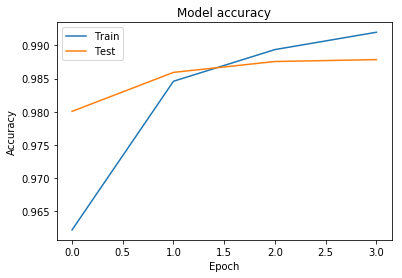

In [26]:
# History plots
plt.figure()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'])
plt.show()

After one Epoch the test accuracy is slightly decreased however the Train accuracy is increasing, this is a sign of overfitting 